In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import adfuller
from scipy.interpolate import interp1d
from tqdm.auto import tqdm
import warnings
from pathlib import Path

warnings.filterwarnings("ignore")

# Set style for the plots
plt.style.use('seaborn-v0_8')

In [3]:
df = pd.read_csv('../data/processed/water_levels_daily.csv', parse_dates=['timestamp'])
series = df.set_index('timestamp')['value'].asfreq('W')

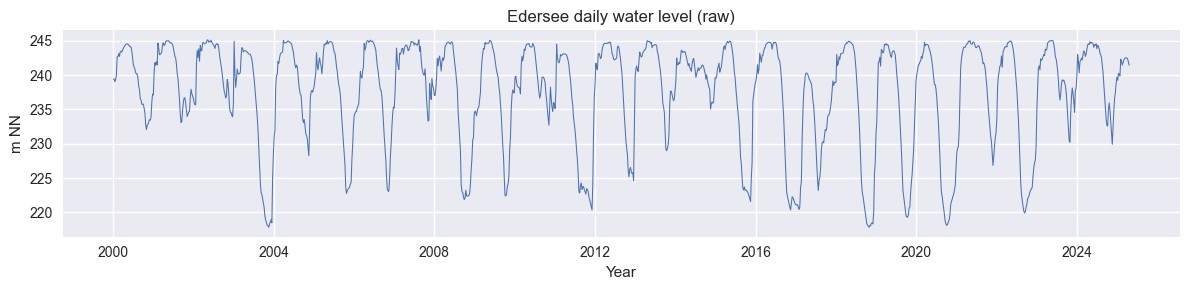

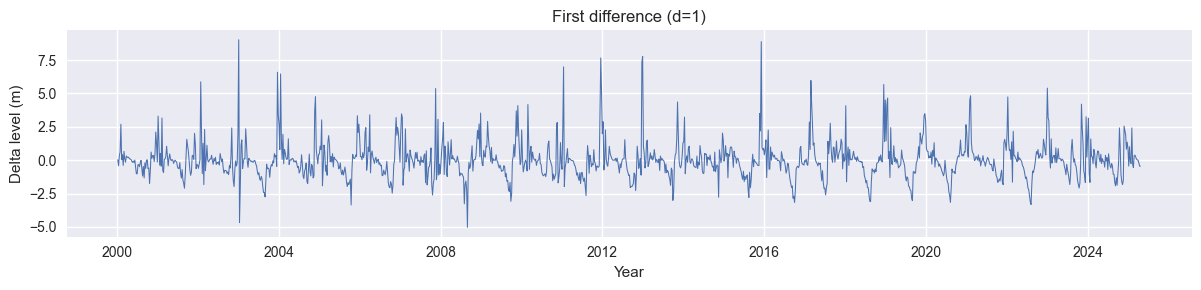

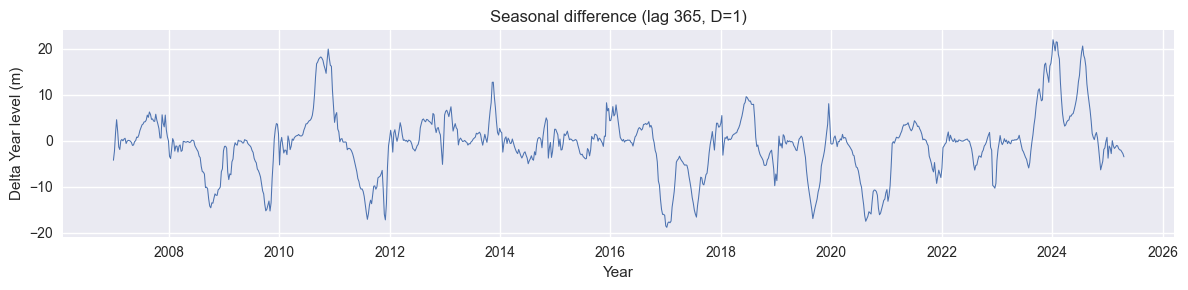

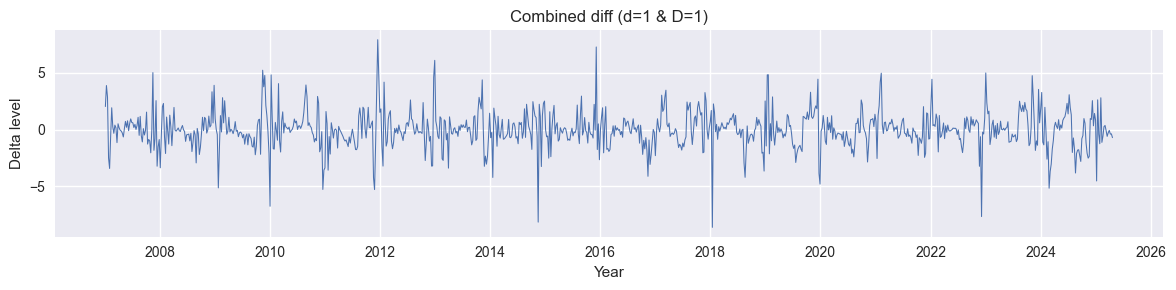

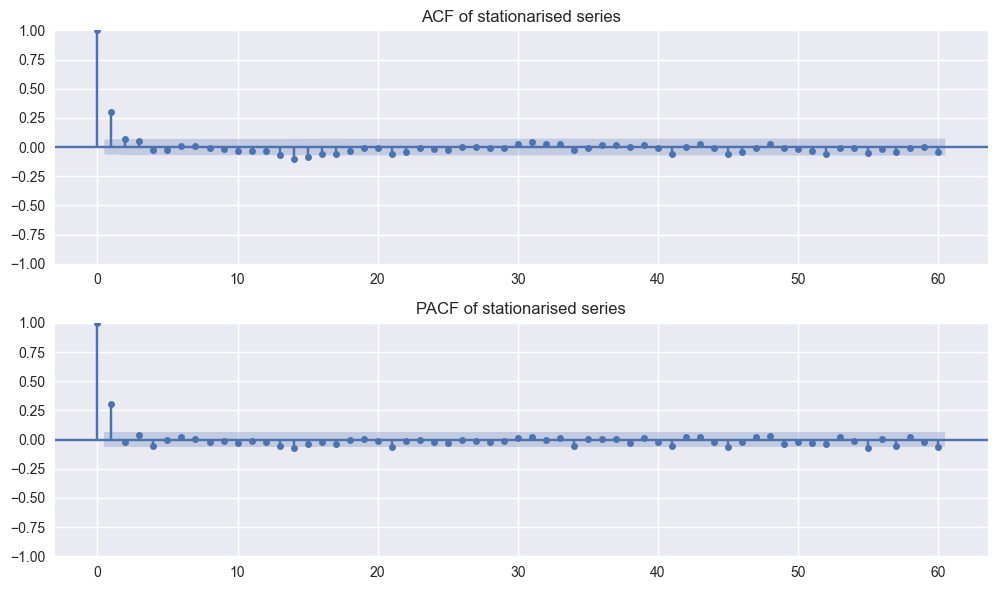

In [4]:
# ---- 1. Raw series ----
plt.figure(figsize=(12,3))
plt.plot(series, linewidth=0.75)
plt.title("Edersee daily water level (raw)")
plt.xlabel("Year")
plt.ylabel("m NN")
plt.tight_layout()
plt.show()

# ---- 2. Non‑seasonal diff (d=1) ----
d1 = series.diff().dropna()
plt.figure(figsize=(12,3))
plt.plot(d1, linewidth=0.75)
plt.title("First difference (d=1)")
plt.xlabel("Year")
plt.ylabel("Delta level (m)")
plt.tight_layout()
plt.show()

# ---- 3. Seasonal diff (lag 365, D=1) ----
D1 = series.diff(365).dropna()
plt.figure(figsize=(12,3))
plt.plot(D1, linewidth=0.75)
plt.title("Seasonal difference (lag 365, D=1)")
plt.xlabel("Year")
plt.ylabel("Delta Year level (m)")
plt.tight_layout()
plt.show()

# ---- 4. Combined diff ----
d1D1 = d1.diff(365).dropna()
plt.figure(figsize=(12,3))
plt.plot(d1D1, linewidth=0.75)
plt.title("Combined diff (d=1 & D=1)")
plt.xlabel("Year")
plt.ylabel("Delta level")
plt.tight_layout()
plt.show()

# ---- 5. ACF & PACF for combined diff ----
fig, ax = plt.subplots(2, 1, figsize=(10,6))
plot_acf(d1D1, ax=ax[0], lags=60)
plot_pacf(d1D1, ax=ax[1], lags=60, method='ywm')
ax[0].set_title("ACF of stationarised series")
ax[1].set_title("PACF of stationarised series")
plt.tight_layout()
plt.show()

In [5]:
adf_stat, adf_p, *_ = adfuller(d1D1, autolag='AIC')
print(f'ADF Statistic: {adf_stat:.3f}')
print(f'p-value: {adf_p:.3f}')

ADF Statistic: -22.628
p-value: 0.000


# Rolling Window Approach

In [6]:
def undiff_sarima(pred_diff,  history, d=1, D=1, s=52):
    """
    Convert forecasts produced with simple_differencing=True back
    to the original scale.

    Parameters
    ----------
    pred_diff : pd.Series
        Forecasts of the differenced series (output of get_forecast).
        Its index must be consecutive to `history`.
    history : pd.Series
        Full original series used to fit the last window *including*
        the final observation y_t.
    d, D, s : int
        Non-seasonal order, seasonal order and period used in the model.

    Returns
    -------
    pd.Series  --  forecasts on the level of `history`.
    """
    y = history.copy()
    out = []
    for w in pred_diff:                       # iterate over the steps 1…h
        level = w
        if D:
            level += y.iloc[-s]               # add y_{t+h-s}
            if d:
                level -= y.iloc[-s-1]         # subtract y_{t+h-s-1}
        if d:
            level += y.iloc[-1]               # add y_{t+h-1}

        new_index = y.index[-1] + pd.offsets.Week()
        y.loc[new_index] = level              # append for subsequent steps
        out.append(level)

    return pd.Series(out, index=pred_diff.index)

In [28]:
# 1. Load raw data and build weekly series (mean over W–SUN weeks)
df = pd.read_csv('../data/processed/water_levels_daily.csv', parse_dates=['timestamp'])

w_raw = (
    pd.read_csv("../data/raw/edersee_historical_weather.csv",
                skiprows=3, parse_dates=["time"])
      .rename(columns={"time": "timestamp"})            # same rename
      .set_index("timestamp")
      .sort_index()
)

weekly = (
    df
    .set_index('timestamp')['value']
    .resample('W-SUN')
    .mean()
    .interpolate()
)

weather_w = (
    w_raw[["soil_moisture_0_to_100cm_mean (m³/m³)"]]
      .rename(columns={"soil_moisture_0_to_100cm_mean (m³/m³)": "soil_moisture"})
      .resample("W-SUN")
      .agg({"soil_moisture": "mean"})
      .interpolate(limit=2)              # tiny gaps at resampling edges
)

# 2. Define validation window and index for rolling forecast
valid = weekly['2018-01-01':'2020-12-31']
idx   = valid.index

# 3. Precompute Fourier features for annual seasonality (52-week period)
periods = [52]
t = np.arange(len(weekly))
fourier_terms = pd.DataFrame(index=weekly.index)
for P in periods:
    fourier_terms[f"sin_{P}w"] = np.sin(2 * np.pi * t / P)
    fourier_terms[f"cos_{P}w"] = np.cos(2 * np.pi * t / P)
    
    
exog_all = pd.concat([fourier_terms, weather_w], axis=1).sort_index()

# 4. Anchor points for Hochwasserschutzraum (Pegel in m ü. NN)
anchor_template  = [
    ("11-01", 237.30),
    ("12-15", 237.30),
    ("01-01", 239.61),
    ("02-01", 241.71),
    ("03-01", 242.70),
    ("04-01", 244.10),
    ("05-01", 244.95),
]

# 5. Function to compute the weekly “max_level” by piecewise-linear interp
def compute_max_level_series(dates):
    def max_level_on(date):
        # determine the “management year” Nov1(date.year)→May1(date.year+1)
        y0 = date.year if date.month >= 11 else date.year - 1
        # build the seven anchor datetimes for this cycle
        pts = []
        for md, lvl in anchor_template:
            mon, day = map(int, md.split("-"))
            year = y0 if mon >= 11 else y0 + 1
            pts.append((pd.Timestamp(year, mon, day), lvl))
        pts.sort(key=lambda x: x[0])
        # if before Nov 1 or after May 1: full stau
        if date < pts[0][0] or date >= pts[-1][0]:
            return pts[-1][1]
        # find segment containing date
        for (d0, l0), (d1, l1) in zip(pts, pts[1:]):
            if d0 <= date <= d1:
                frac = (date - d0) / (d1 - d0)
                return l0 + frac * (l1 - l0)
        # fallback
        return pts[-1][1]

    return pd.Series([max_level_on(d) for d in dates], index=dates, name="max_level_m")

# compute the dynamic max_level at weekly timestamps
max_level = compute_max_level_series(weekly.index)

# 8. Rolling‐window SARIMAX forecast with dynamic capping
window_weeks   = 5 * 52
order          = (1, 1, 0)
seasonal_order = (0, 0, 0, 0)  # seasonality via Fourier
horizon        = 4
MIN_VAL        = 205           # plausible physical minimum

pred_vals, ci_low, ci_high = [], [], []
cached_params = None

pbar = tqdm(total=len(idx), desc="Rolling forecast")
for target_date in idx:
    # 8a. Define training window
    train_end   = target_date - pd.offsets.Week(horizon)
    train_start = train_end - pd.offsets.Week(window_weeks - 1)
    y_window    = weekly.loc[train_start:train_end]

    # 8b. Slice exogenous for fit & forecast
    exog_train = exog_all.loc[train_start:train_end]
    fc_index   = pd.date_range(train_end + pd.offsets.Week(),
                               periods=horizon, freq='W-SUN')
    exog_fc    = exog_all.reindex(fc_index)

    # 8c. Specify and fit SARIMAX
    mod = SARIMAX(
        y_window,
        exog=exog_train,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False,
        filter_concentrated=True
    )
    res = mod.fit(
        disp=False,
        start_params=None if cached_params is None else cached_params,
        method="lbfgs",
        maxiter=50,
        hessian=False
    )
    cached_params = res.params

    # 8d. Forecast 4 weeks ahead
    fc = res.get_forecast(steps=horizon, exog=exog_fc)
    yhat_raw       = fc.predicted_mean.iloc[-1]
    lo_raw, hi_raw = fc.conf_int().iloc[-1]

    # 8e. Apply dynamic upper cap according to Hochwasserschutzraum
    dyn_max = max_level.loc[target_date]
    yhat    = min(max(yhat_raw, MIN_VAL), dyn_max)
    lo      = min(max(lo_raw,   MIN_VAL), dyn_max)
    hi      = min(max(hi_raw,   MIN_VAL), dyn_max)

    pred_vals.append(yhat)
    ci_low .append(lo)
    ci_high.append(hi)

    pbar.update()
pbar.close()

Rolling forecast:   0%|          | 0/156 [00:00<?, ?it/s]

In [29]:
# Results of the last estimation
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  260
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -288.862
Date:                Sat, 03 May 2025   AIC                            589.723
Time:                        15:34:19   BIC                            611.041
Sample:                    12-13-2015   HQIC                           598.295
                         - 11-29-2020   Scale                            0.900
Covariance Type:                  opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
sin_52w           6.3627      1.966      3.237      0.001       2.510      10.216
cos_52w          -7.1693      1.741     -4.119      0.000     -10.581      -3.758
soil_moisture    13.1730      3.504      3.759      0.000       6.305      20.041
ar.L1             0.6861      0.034     20.054      0.000       0.619       0.753
sigma2            0.6107   4.04e-12   1.51e+11      0.000       0.611       0.611
===================================================================================
Ljung-Box (L1) (Q):                   0.35   Jarque-Bera (JB):               494.87
Prob(Q):                              0.55   Prob(JB):                         0.00
Heteroskedasticity (H):               0.53   Skew:                             1.52
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.48e+39. Standard errors may be unstable.
"""

In [30]:
rolling_pred = pd.Series(pred_vals, index=valid.index, name="y_hat")
ci_lo        = pd.Series(ci_low,   index=valid.index, name="lo_95")
ci_hi        = pd.Series(ci_high,  index=valid.index, name="hi_95")

mask = rolling_pred.notna() & valid.notna()

mae  = mean_absolute_error(valid[mask], rolling_pred[mask])
rmse = math.sqrt(mean_squared_error(valid[mask], rolling_pred[mask]))

metrics_df = pd.DataFrame(
    {"Metric": ["MAE", "RMSE"],
     "Value":  [mae,   rmse]}
)

metrics_df

,Metric,Value
0,MAE,1.620923
1,RMSE,2.386201


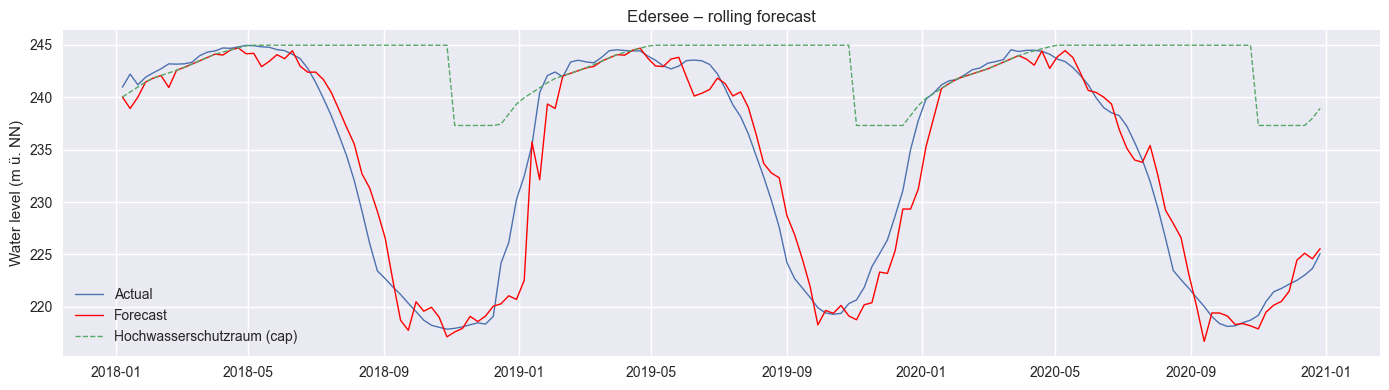

In [31]:
ml_valid = max_level.reindex(valid.index).ffill().bfill()

fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(valid, label="Actual", linewidth=1)
ax.plot(rolling_pred, label="Forecast", linewidth=1, color="red")
ax.plot(ml_valid.index, ml_valid, label="Hochwasserschutzraum (cap)", linestyle="--", linewidth=1)
ax.set_ylabel("Water level (m ü. NN)")
ax.set_title("Edersee – rolling forecast")
ax.legend(loc="lower left")
plt.tight_layout()
plt.show()

,lb_stat,lb_pvalue
20,210.357861,9.940365e-34
40,317.637080,6.500305e-45


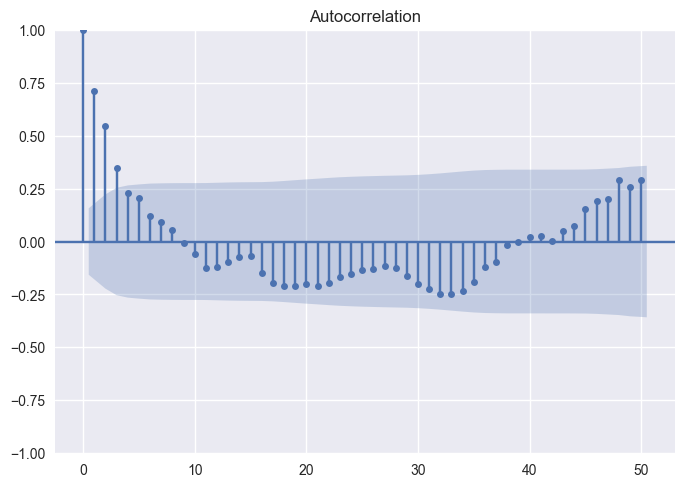

In [32]:
resid = valid - rolling_pred
plot_acf(resid, lags=50)
acorr_ljungbox(resid, lags=[20,40])